# Treść zadania

Producenci i konsumenci z losowa ilością pobieranych i wstawianych porcji:

- Bufor o rozmiarze `2M`
- Jest `m` producentów i `n` konsumentów
- Producent wstawia do bufora losową liczbę elementów (nie więcej niż `M`)
- Konsument pobiera losową liczbę elementów (nie więcej niż `M`)
- Zaimplementować przy pomocy *monitorów Javy* oraz mechanizmów *Java Concurrency Utilities*
- Przeprowadzić porównanie wydajności (np. czas wykonywania) vs. różne parametry, zrobić wykresy i je skomentować

# Rozwiązanie

Przed aktualnym rozpoczęciem rozwiązania warto najpierw przypomnieć, na czym dokładnie polega problem
producentów-konsumerów (Producer-consumer problem).

**Problem producenta i konsumenta** - klasyczny informatyczny problem synchronizacji. W problemie występują
dwa rodzaje procesów: producent i konsument, którzy dzielą wspólny zasób – bufor – dla produkowanych (i konsumowanych)
jednostek. Zadaniem producenta jest wytworzenie produktu, umieszczenie go w buforze i rozpoczęcie pracy od
nowa. W tym samym czasie konsument ma pobrać produkt z bufora. Problemem jest taka synchronizacja procesów,
żeby producent nie dodawał nowych jednostek gdy bufor jest pełny, a konsument nie pobierał gdy bufor jest pusty.

Struktura rozwiązania wygląda następująco:

```
tw-lab4/src/main/java/pl/edu/agh/tw/knapp/lab4
    Box.java
    Buffer.java
    Consumer.java
    Logger.java
    Main.java
    Producer.java
    RandomSleeper.java
    SemaphoreBuffer.java
    WorkerThread.java
```

Poniżej zostaną opisane poszczególne klasy.

## `Buffer<T>`

Jest to klasa reprezentująca interfejs bufora.

```java
// Buffer.java

package pl.edu.agh.tw.knapp.lab4;

import java.util.List;

public interface Buffer<T> {
    /**
     * Puts the specified values to the buffer
     * @param values The values to put
     * @return `true` if success, `false` otherwise
     */
    boolean put(List<T> values);

    /**
     * Returns the specified amount of elements from the buffer
     * @param amount The amount of elements to return
     * @return The elements from the buffer
     */
    List<T> get(int amount);

    /**
     * Returns the capacity, i.e. the maximum count of elements
     * that the buffer can hold
     * @return The buffer's capacity
     */
    int capacity();
}
```

- Metoda `put` służy do umiszczenia elementów z listy `values` w buforze
- Metoda `get` zwraca określoną liczbę elementów bufora jako listę
- Metoda `capacity` zwraca maksymalną liczbę elementów które mogą być przechowywane w buforze naraz (pojemność)

## `SemaphoreBuffer<T>`

Implementacja bufora za pomocą semaforów. Również w celach synchronizacji skorzystano z monitorów (metod synchronicznych).

```java
// SemaphoreBuffer.java

package pl.edu.agh.tw.knapp.lab4;

import java.nio.BufferOverflowException;
import java.nio.BufferUnderflowException;
import java.util.ArrayList;
import java.util.Collections;
import java.util.List;
import java.util.concurrent.Semaphore;
import java.util.concurrent.TimeUnit;

public class SemaphoreBuffer<T> implements Buffer<T> {
    private final List<T> buffer;
    private int bufferPos = 0;
    private int bufferActualSize = 0;

    private final long timeoutMs;

    private final Semaphore readyPortions;
    private final Semaphore availablePositions;

    public SemaphoreBuffer(int size) {
        this(size, 1000L);
    }

    public SemaphoreBuffer(int size, long timeoutMs) {
        this.timeoutMs = timeoutMs;
        buffer = new ArrayList<>(Collections.nCopies(size, null));
        readyPortions = new Semaphore(0);
        availablePositions = new Semaphore(size);
    }

    private boolean tryAcquireUninterruptibly(Semaphore semaphore, int permits) {
        try {
            if (timeoutMs > 0L) {
                return semaphore.tryAcquire(permits, timeoutMs, TimeUnit.MILLISECONDS);
            } else {
                semaphore.acquire(permits);
                return true;
            }
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    private synchronized void addAll(List<T> values) {
        for (var val : values) {
            var index = (bufferPos + bufferActualSize) % capacity();
            ++bufferActualSize;
            buffer.set(index, val);
        }
    }

    @Override
    public boolean put(List<T> values) {
        if (values.size() > capacity())
            throw new BufferOverflowException();

        if (!tryAcquireUninterruptibly(availablePositions, values.size()))
            return false;

        addAll(values);

        readyPortions.release(values.size());

        return true;
    }

    private synchronized List<T> getAll(int amount) {
        List<T> result = new ArrayList<>(amount);

        for (int i = 0; i < amount; ++i) {
            result.add(buffer.get(bufferPos));
            bufferPos = (bufferPos + 1) % capacity();
            --bufferActualSize;
        }

        return result;
    }

    @Override
    public List<T> get(int amount) {
        if (amount > capacity())
            throw new BufferUnderflowException();

        if (!tryAcquireUninterruptibly(readyPortions, amount))
            return List.of();

        var result = getAll(amount);

        availablePositions.release(amount);

        return result;
    }

    @Override
    public int capacity() {
        return buffer.size();
    }
}
```

## `Logger`

Jest to klasa służąca do wypisywania logów. Podczas implementacji, w celach ułatwienia zarządzaniem logami,
użyto wzorca *Singleton*.

```java
// Logger.java

package pl.edu.agh.tw.knapp.lab4;

import java.util.function.Consumer;

public class Logger {
    private static final Logger logger = new Logger();

    private Consumer<String> consumer = defaultConsumer();
    
    private static Consumer<String> defaultConsumer() {
        return System.out::println;
    }

    private Logger() {
        // empty
    }

    public void log(String tag, Object o) {
        consumer.accept(String.format("[%s] %s", tag, o));
    }

    public void log(Object o) {
        consumer.accept(String.valueOf(o));
    }

    public void setConsumer(Consumer<String> consumer) {
        this.consumer = consumer;
    }

    public void mute() {
        setConsumer(s -> {});
    }
    
    public void unmute() {
        setConsumer(defaultConsumer());
    }

    public static Logger getInstance() {
        return logger;
    }
}
```

- `log(String tag, Object o)` wypisuje log wraz z tagiem (np. *Consumer*, *Producer* itd. Chodzi tu o
  rozpoznanie źródła pochodzenia informacji). Obiekt `o` może mieć wartość `null`.
- `log(Object o)` wypisuje tekstową reprezentację obiektu `o`. Obiekt `o` może mieć wartość `null`.
- `setConsumer(Consumer<String> consumer)` umożliwia ustawienie kastomowego konsumenta logów. **Uwaga:**
  `Consumer<T>` pochodzi z pakietu `java.util.function`!
- `mute()` wycisza Logger
- `unmute()` przeciwieństwo metody `mute`: jako konsument zostanie użyta domyślna implementacja wypisująca
  na standardowym wyjściu
- `getInstance()` zwraca instancję klasy `Logger`

## `RandomSleeper`

Klasa służąca do uśpienia wątku na pewien czas, losowany z przedziału `[delayMinMs, delayMaxMs)`.

```java
// RandomSleeper.java

package pl.edu.agh.tw.knapp;

import java.util.Random;

public class RandomSleeper {
    private final Random delayRandom = new Random();
    private final long delayMinMs;
    private final long delayMaxMs;

    public RandomSleeper(long delayMinMs, long delayMaxMs) {
        this.delayMinMs = delayMinMs;
        this.delayMaxMs = delayMaxMs;
    }

    public void sleep() throws InterruptedException {
        if (delayMinMs == 0 && delayMaxMs == 0)
            return;
        var delay = delayRandom.nextLong(delayMinMs, delayMaxMs);
        Thread.sleep(delay);
    }
}
```

## `Box<T>`

Służy do przechowywania wartości typu `T`. Pozwala na tworzenie `final` referencji i zmianę przechowywanej wartości.

```java
package pl.edu.agh.tw.knapp.lab4;

public class Box<T> {
    private T value;

    public Box() {
        // empty
    }

    public Box(T value) {
        this.value = value;
    }

    public T getValue() {
        return value;
    }

    public void setValue(T value) {
        this.value = value;
    }

    @Override
    public String toString() {
        return "Box {" + value + '}';
    }
}
```

## `WorkerThread<T>`

Klasa nadrzędna dla producentów i konsumentów. Zawiera referencję na bufor, udostępnia funkcje używane w klasach potomnych.

```java
// WorkerThread.java

package pl.edu.agh.tw.knapp.lab4;

import java.util.Random;
import java.util.function.Function;

public class WorkerThread<T> extends Thread {
    private final static Logger logger = Logger.getInstance();

    protected final Buffer<T> buff;
    private final RandomSleeper randomSleeper;

    private final int iterCount;

    private final Random randM = new Random();
    private final int m;

    /**
     * The main constructor
     * @param buff The buffer to get from
     * @param delayMinMs The minimum random delay, in ms
     * @param delayMaxMs The maximum random delay, in ms
     * @param iterCount The number of iterations
     * @param m The consumed element count upper bound
     */
    public WorkerThread(
            Buffer<T> buff,
            long delayMinMs, long delayMaxMs,
            int iterCount, int m
    ) {
        this.buff = buff;
        randomSleeper = new RandomSleeper(delayMinMs, delayMaxMs);
        this.iterCount = iterCount;
        this.m = m;
    }

    public WorkerThread(Buffer<T> buff) {
        this(buff, 0, 0, 100, 10);
    }

    public int getIterCount() {
        return iterCount;
    }

    protected void randomDelay() throws InterruptedException {
        randomSleeper.sleep();
    }

    protected void log(Object o) {
        logger.log(String.format("%s id %s", getClass().getSimpleName(), getId()), o);
    }

    protected void iterate(Function<Integer, Boolean> function) {
        for (int i = 0; i < iterCount; i++) {
            try {
                randomDelay();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }

            if (!function.apply(i)) {
                break;
            }
        }
    }

    protected int getRandomizedM() {
        return randM.nextInt(m) + 1;
    }
}
```

Jeżeli przyczyna istnienia większości metod jest oczywista i została wielokrotnie omówiona w sprawozdaniach
z poprzednich laboratoriów, metoda `iterate` jest nowością i zasługuje na krótki opis.

Metoda `iterate` służy do przeiterowania pętlą od `0` do `iterCount - 1` (włącznie), ponadto:

1. Przed każdą iteracją wątek zostanie uśpiony na pewien czas, losowany z przedziału `[delayMinMs, delayMaxMs)`
2. Następnie zostanie wywołany callback `function` z argumentem reprezentującym indeks iteracji
3. Jeżeli callback zwróci `false`, pętla zostanie przerwana

Ta metoda jest głównie po to, aby uprościć implementacje producenta i konsumenta.

## `Consumer`

Implementacja konsumenta pobierającego pewną liczbę elementów z buforu, losowaną za pomocą funkcji `WorkerThread#getRandomizedM`,
i następnie wypisującego te elementy.

```java
// Consumer.java

package pl.edu.agh.tw.knapp.lab4;

public class Consumer extends WorkerThread<Integer> {

    public Consumer(
            Buffer<Integer> buff,
            long delayMinMs, long delayMaxMs,
            int iterCount, int m
    ) {
        super(buff, delayMinMs, delayMaxMs, iterCount, m);
    }

    public Consumer(Buffer<Integer> buff) {
        super(buff);
    }

    @Override
    public void run() {
        iterate(i -> {
            var values = buff.get(getRandomizedM());

            if (!values.isEmpty()) {
                log(values);
            } else {
                log("Buffer#get: end reached, iter " + i);
            }

            return !values.isEmpty();
        });
    }
}
```

## `Producer`

Implementacja konsumenta produkującego pewną liczbę elementów, losowaną za pomocą funkcji `WorkerThread#getRandomizedM`,
i następnie umieszczającego te elementy w buforze.

Wartość generowanego elementu jest obliczana według następującego wzoru:

$$ s = \lfloor tid \cdot 10^{\lfloor \log_{10}{iterCount} + 1 \rfloor} \rfloor $$
$$ e_j = s + j + \sum_{k=-1}^{j - 1} m_k, \quad j \in [0, m), \enspace m_{-1} = 0 $$

gdzie $s$ - wartość początkowa, $tid$ - thread id, $e_j$ - wartość $j$-tego elementu, $m_k$ jest obliczane za pomocą
funkcji `WorkerThread#getRandomizedM`.

Obliczona w taki sposób wartość elementu umożliwi obserwowanie wartości pobieranych przez poszczególnych konsumentów.
Takie podejście gwarantuje, iż wszystkie wyprodukowane przez producentów wartości będą unikalne, obliczone na podstawie
id wątków, w których ci producenci zostali uruchomieni.

```java
package pl.edu.agh.tw.knapp.lab4;

import java.util.stream.IntStream;

public class Producer extends WorkerThread<Integer> {

    public Producer(
            Buffer<Integer> buff,
            long delayMinMs, long delayMaxMs,
            int iterCount, int m
    ) {
        super(buff, delayMinMs, delayMaxMs, iterCount, m);
    }

    public Producer(Buffer<Integer> buff) {
        super(buff);
    }

    @Override
    public void run() {
        log("Producer started");

        Box<Integer> counter =
            new Box<>((int) (getId() * Math.pow(10, (int) Math.log10(getIterCount()) + 1)));

        iterate(i -> {
            int counterVal = counter.getValue();
            int m = getRandomizedM();

            var elements = IntStream.range(counterVal, counterVal + m).boxed().toList();

            counter.setValue(counterVal + m);

            if (!buff.put(elements)) {
                log("Buffer#put error, iter " + i);
                return false;
            }

            return true;
        });
    }
}
```

## `Main`

Klasa główna. Zawiera metody, umożliwiające korzystanie ze stworzonego mechanizmu.

- Jeżeli do funkcji `main` żadne argumenty nie zostaną przekazane, zostaną użyte domyślne parametry:

  1. `p = 10`
  2. `c = 10`
  3. `iterCount = 100`
  4. `bufferSize = 100`
  5. `bufferTimeout = 1000`
  6. `m = -1`
  7. Logger jest włączony

  gdzie `p` - liczba producentów, `c` - liczba konsumentów. `iterCount` - liczba iteracji, `bufferSize` - rozmiar bufora,
  `bufferTimeout` - maksymalny czas oczekiwania na odczyt/zapis wartości z/do bufora, po przekroczeniu tego czasu operacja
  zostanie przerwana, `m` - górny próg liczby elementów, które zostaną wyprodukowane przez producenta (pobrane przez konsumenta)
  w jednej iteracji, jeżeli `m == -1`, to `m = bufferSize / 2`

- Jeżeli do funkcji `main` zostaną przekazane argumenty, to:
  
  1. `p = args[0]`
  2. `c = args[1]`
  3. `iterCount = args[2]`
  4. `bufferSize = args[3]`
  5. `bufferTimeout = args[4]`
  6. `m = args[5]`
  7. Jeżeli `args[6]` istnieje, to gdy ma wartość `disable-output`, Logger zostanie wyciszony

- Niezaleznie od tego, czy Logger jest wyciszony czy nie, zostanie wypisany czas wykonania w postaci `time=...`

Klasa `Main` jest zaimplementowana następująco:

```java
// Main.java

package pl.edu.agh.tw.knapp.lab4;

import java.util.List;
import java.util.stream.Stream;

public class Main {
    private static final long CONSUMER_MIN_DELAY = 0;
    private static final long CONSUMER_MAX_DELAY = 0;

    private static final long PRODUCER_MIN_DELAY = 0;
    private static final long PRODUCER_MAX_DELAY = 0;

    private static final Logger logger = Logger.getInstance();

    /**
     * The application's entry point
     * @param args The arguments list:<br>
     *   args[0]: The producer count<br>
     *   args[1]: The consumer count<br>
     *   args[2]: The iteration count (for both producers and consumers)<br>
     *   args[3]: The buffer size<br>
     *   args[4]: The buffer timeout, in ms<br>
     *   args[5]: The upper bound of produced/consumed element count
     *            in one iteration. If `-1`, `buffer.capacity() / 2` will be used<br>
     *   args[6]: (optional) Output params, valid values: 'disable-output'
     */
    public static void main(String[] args) throws InterruptedException {
        int p = 10;
        int c = 10;
        int iterCount = 100;
        int bufferSize = 100;
        int bufferTimeout = 1000;
        int m = -1;

        if (args.length > 0) {
            if (args.length != 6 && args.length != 7) {
                throw new IllegalArgumentException(String.format(
                    "Unexpected argument count: expected 0, 6 or 7, got %s", args.length));
            }

            p = Integer.parseInt(args[0]);
            c = Integer.parseInt(args[1]);
            iterCount = Integer.parseInt(args[2]);
            bufferSize = Integer.parseInt(args[3]);
            bufferTimeout = Integer.parseInt(args[4]);
            m = Integer.parseInt(args[5]);

            if (args.length == 7) {
                if (args[6].equals("disable-output")) {
                    logger.mute();
                } else {
                    throw new IllegalArgumentException(String.format(
                        "Illegal argument: '%s'", args[6]));
                }
            }
        }

        System.out.printf("time=%s\n",
                demo(p, c, iterCount, m, new SemaphoreBuffer<>(bufferSize, bufferTimeout)));
    }

    private static long demo(
            int p, int c,
            int iterCount, int m,
            Buffer<Integer> buffer
    ) throws InterruptedException {
        logger.log(
            String.format("******* producers = %s, consumers = %s, buffer: %s *******\n",
                p, c, buffer.getClass().getSimpleName()));

        int validM = m == -1 ? buffer.capacity() / 2 : m;

        var consumers = Stream.generate(() -> mkConsumer(buffer, iterCount, validM))
                .limit(c)
                .toList();

        var producers = Stream.generate(() -> mkProducer(buffer, iterCount, validM))
                .limit(p)
                .toList();

        long startTime = System.currentTimeMillis();

        consumers.forEach(Thread::start);
        producers.forEach(Thread::start);

        joinAll(producers);
        joinAll(consumers);

        long elapsedTime = System.currentTimeMillis() - startTime;

        logger.log("Done in " + elapsedTime + " ms");

        return elapsedTime;
    }

    private static Consumer mkConsumer(Buffer<Integer> buffer, int iterCount, int m) {
        return new Consumer(buffer, CONSUMER_MIN_DELAY, CONSUMER_MAX_DELAY, iterCount, m);
    }

    private static Producer mkProducer(Buffer<Integer> buffer, int iterCount, int m) {
        return new Producer(buffer, PRODUCER_MIN_DELAY, PRODUCER_MAX_DELAY, iterCount, m);
    }

    private static void joinAll(List<? extends Thread> threads) throws InterruptedException {
        for (var thread : threads) {
            thread.join();
        }
    }
}
```

> Uwaga: wyniki można znaleźć w odpowiednim rozdziale.

> To zadanie może zostać uruchomione korzystając z polecenia
> ```bash
> ./gradlew run
> ```

# Wyniki

W tym rozdziale zostały umieszczone wyniki (pomiary wydajności) powyższego rozwiązania.

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.5.6-200.fc38.x86_64
- openjdk 17.0.8 2023-07-18

Dodatkowo, w celach otrzymania i przetwarzania wyników został użyty język `python 3.11.6`, biblioteka
`matplotlib 3.8.0`, służąca do rysowania wykresów, oraz `numpy 1.24.3`, służąca do obliczeń numerycznych.

Ponadto, żeby ułatwić proces uruchomienia projektu, skorzystano z narzędzia `gradle` (Kotlin DSL).

## Pobieranie wyników

W tej części zostaną pobrane wyniki dla następujących przypadków:

1. Stała liczba producentów, zmienna liczba konsumentów
2. Zmienna liczba producentów, stała liczba konsumentów
3. Ta sama liczba producentów i konsumentów, zmienna liczba iteracji
4. Stały rozmiar bufora, zmienna liczba jednocześnie pobieranych / wstawianych elementów

W tym celu najpierw warto stworzyć liste testowanych parametrów:

In [1]:
class ParamSet:
    def __init__(self, name: str, x_name: str, x_values, template: dict[str, int]) -> None:
        self.name = name
        self.x_name = x_name
        self.values = [
            {x_name: val} | template.copy()
            for val in x_values
        ]
    
    def __str__(self) -> str:
        return str(self.__dict__)
    
    def __repr__(self) -> str:
        return self.__str__()


params = [
    # param set 1
    ParamSet("Variable consumer count", "c", [int(i**1.5) for i in range(4, 60, 3)], {
        "p": 25,
        "iterCount": 100,
        "bufferSize": 1000,
        "bufferTimeout": 500,
        "m": -1
    }),

    # param set 2
    ParamSet("Variable producer count", "p", [int(i**1.5) for i in range(4, 60, 3)], {
        "c": 25,
        "iterCount": 100,
        "bufferSize": 1000,
        "bufferTimeout": 500,
        "m": -1
    }),

    # param set 3
    ParamSet("Variable iteration count", "iterCount", range(10, 201, 5), {
        "p": 10,
        "c": 10,
        "bufferSize": 100,
        "bufferTimeout": 1000,
        "m": -1
    }),

    # param set 4
    ParamSet("Variable upper bound of produced/consumed element count", "m", range(1, 500, 4), {
        "p": 10,
        "c": 10,
        "iterCount": 100,
        "bufferSize": 1000,
        "bufferTimeout": 500,
    })
]

Następnie tworzę funkcję, która będzie wywoływać program Javowy z określonymi parametrami i jako wynik zwracać
czas wykonania obliczeń wypisany przez Javowy program:

In [2]:
import subprocess
import re

def run(p: dict[str, int]) -> int:
    cmd = "../tw-lab4/gradlew run --args=\"{} {} {} {} {} {} disable-output\"".format(
        p['p'], p['c'], p['iterCount'], p['bufferSize'], p['bufferTimeout'], p['m']
    )

    result = subprocess.run(
        ["bash", "-c", cmd],
        cwd="../tw-lab4",
        stdout=subprocess.PIPE)
    
    return int(re.search("time=([0-9]+)", str(result.stdout)).group(1))

Tworzę funkcję, która dla podanych argumentów zwraca średni czas wykonania:

In [3]:
import numpy as np

def run_mean(p: dict[str, int], n=15) -> float:
    return np.mean([run(p) for _ in range(n)], dtype=float)

Następnie tworzę funkcję, która dla podanego `ParamSet` zwraca listę średnich czasów wykonania:

In [4]:
def get_times_for(pset: ParamSet, debug=True) -> list[float]:
    if debug:
        print(f"Processing ParamSet with x_name={pset.x_name}")

    return [run_mean(p) for p in pset.values]

Wreszcie, tworzę listę wyników dla poszczególnych param setów:

In [5]:
%store -r times

In [6]:
try:
    times
except NameError:
    print("'times' variable doesn't exist, performing calculations from scratch")
    times = [get_times_for(pset) for pset in params]
else:
    print("'times' variable exists - no calculations will be performed")

'times' variable exists - no calculations will be performed


Uwaga: powyższe obliczenia trwały ponad 73 minuty.

In [7]:
%store times

Stored 'times' (list)


Mamy listę parametrów `params` oraz listę pomiarów `times`, a więc możemy przejść do następnej części - wykresów.

## Wykresy

W celu rysowania wykresów, tworzę pomocnicze funkcje:

- `show_plot`, która zajmie się rysowaniem wykresów w oparciu o `ParamSet` oraz odpowiednią listę pomiarów
- `regression_fit_degree`, służącą do dopasowania stopnia wielomianu interpolującego do danych. Aby uniknąć
  overfittingu, korzystam z następującej funkcji kosztu:

  $$ cost = \sum_{j=1}^{n} \left(y_j - \widehat{y}_j\right)^2 + 0.25 \cdot i^2 $$

  gdzie $i$ - indeks iteracji, $n$ - liczba punktów

In [8]:
import matplotlib.pyplot as plt

def regression_fit_degree(x, y):
    # cost, degree
    min_cost_info = (float("inf"), 0)

    for i in range(1, min(len(x), 8)):
        p = np.poly1d(np.polyfit(x, y, i))

        cost = np.sum(y - p(x))**2 + 0.25 * i**2

        if cost < min_cost_info[0]:
            min_cost_info = (cost, i)
    
    return min_cost_info[1]

def show_plot(pset: ParamSet, results: list[float]):
    constants = pset.values[0].copy()
    del constants[pset.x_name]

    x = [v[pset.x_name] for v in pset.values]
    y = results

    t = np.linspace(x[0], x[-1], 100)
    reg_deg = regression_fit_degree(x, y)

    plt.rcParams["figure.figsize"] = (6.4 * 0.8, 4.8 * 0.8)

    plt.plot(x, y, "o", label="Data (mean time)")
    plt.plot(t, np.poly1d(np.polyfit(x, y, reg_deg))(t), "--", label=f"Fitted polynomial of degree {reg_deg}")
    plt.legend(loc="best")
    plt.title(f"{pset.name}\n{constants}")
    plt.xlabel(pset.x_name)
    plt.ylabel("time, $[ms]$")
    plt.show()

Rysuję wszystkie wykresy:

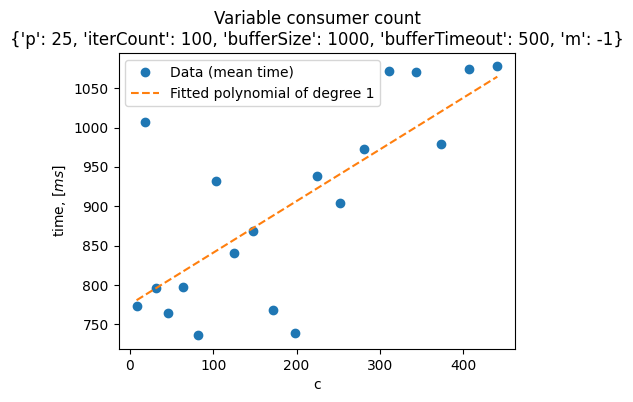

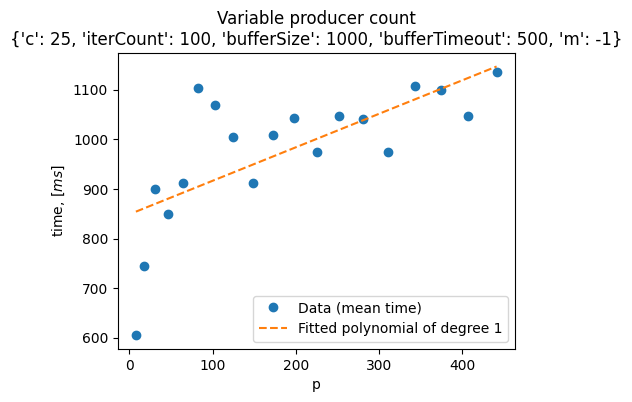

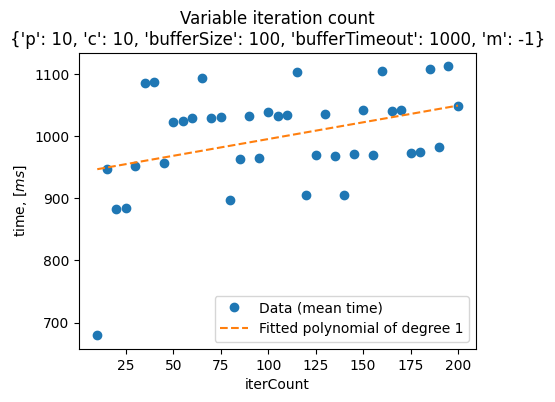

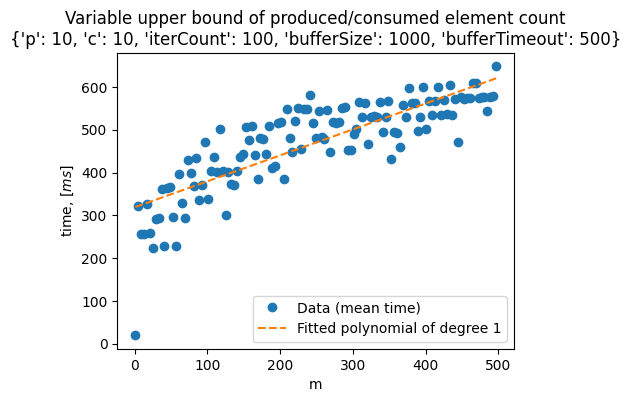

In [9]:
for i in range(len(params)):
    show_plot(params[i], times[i])

# Wnioski

- Problem producentów-konsumentów (producer-consumer problem, bounded-buffer problem) da się rozwiązać
  korzystając z różnych mechanizmów synchronizacji, m.in. semaforów i monitorów
- Czas wykonania zależy od wszystkich parametrów, i im większe te parametry, tym większy jest czas wykonania
- Czas wykonania całego *eksperymentu* wyniósł ponad 73 minuty, co jest zdecydowanie za dużo. Ten czas można zredukować
  na kilka sposobów, między innymi:
  - Skorzystać z mechanizmu wielowątkowości i każdy `ParamSet` obliczać w osobnym wątku (ale wątków tych nie może być 
    więcej od sprzętowej liczby wątków)
  - Większa część czasu wykonania *eksperymentu* to czas potrzebny na uruchomienie narzędzia `gradle`. A więc w celu
    przyspieszenia można zrezygnować z tego narzędzia i uruchamiać projekt ręcznie
- Jak widać z wykresów, wyniki oscylują wokół wielomianu interpolującego, nie są one bardzo dokładne. Wynika to z pewnych
  mechanizmów, użytych w implementacji, a mianowicie z mechanizmu *timeout*. ten mechanizm został wprowadzony w laboratorium 3
  i w skrócie można go opisać następująco (opis klas `Consumer` oraz `Producer` z laboratorium 3):

  > [...] niepowodzenie może wystąpić
  > jeżeli żaden producent nie zapisał do bufora jakiejś wartości w ciągu określonego czasu. Wtedy konsument stwierdza,
  > że "transmisja" jest zakończona i kończy swoje działanie. Ten mechanizm jest niezbędny dla niektórych przypadków, np.
  > gdy liczba konsumentów jest większa od liczby producentów: w celu uniknięcia zawieszenia programu z powodu oczekiwania
  > nowych danych nadanych przez producenta, musimy skorzystać z wyżej opisanego mechanizmu
  >
  > [...] Niepowodzenie może zostać spowodowane tym, że już żaden konsument nie próbuje odczytać wartości z buforu. Ten
  > mechanizm został zaimplementowany z przyczyn opisanych podczas omówienia konsumenta, tylko tym razem liczba producentów
  > może być większa od liczby konsumentów

  i biorąc pod uwagę to, iż do opisanych powyżej sytuacji w przypadku wstawiania / odczytywania losowej liczby elementów
  w sposób oczywisty dochodzimy dość często, mamy dodatkowy narzut czasowy, który może wynieść aż do `bufferTimeout` millisekund.

  Ten problem może zostać rozwiązany zastępując obecne podejście innym, a mianowicie musimy śledzić liczbę aktywnych
  producentów i konsumentów i na tej podstawie podejmować decyzje o przerwaniu czekania. Jest to bardziej zaawansowany mechanizm
  wymagający zaimplementowania dodatkowych klas, np. `ConsumerPool`, `ProducerPool` itd.

# Bibliografia

1. [Materiały do laboratorium 4](https://home.agh.edu.pl/~funika/tw/lab4/)
2. [Materiały do laboratorium 3](https://home.agh.edu.pl/~funika/tw/lab3/)
3. [Wikipedia - Problem producenta i konsumenta](https://pl.wikipedia.org/wiki/Problem_producenta_i_konsumenta)
4. [Wikipedia - Producer-consumer problem](https://en.wikipedia.org/wiki/Producer%E2%80%93consumer_problem)